In [1]:
import numpy as np 
import pandas as pd 
from subprocess import check_output
#print(check_output(["ls", "../input/"]))
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score
from os.path import join as opj
from matplotlib import pyplot as plt
import tensorflow as tf
import os
%matplotlib inline


In [2]:
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation,Add, ZeroPadding2D ,AveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers,regularizers
from keras.optimizers import Adam,SGD
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
K.set_image_data_format('channels_last')
#K.set_learning_phase(1)

Using TensorFlow backend.


In [3]:
train = pd.read_json("input/train.json")
#test = pd.read_json("input/test.json")

In [4]:
only_band1 = ['band1_'+str(i) for i in range(75*75)]
only_band2 = ['band2_'+str(i) for i in range(75*75)]
both_bands = only_band1+only_band2

In [ ]:
# df = pd.concat([pd.DataFrame(test['band_1'].values.tolist(),columns = only_band1),
#                 pd.DataFrame(test['band_2'].values.tolist(),columns = only_band2)],axis = 1)

In [5]:
def collect_test():
    test_data = pd.DataFrame()
    for i in range(4):
        test_piece = pd.read_csv('input/test_subparts/test'+str(i+1)+'.csv')
        test_data = pd.concat([test_data,test_piece])
        test_data = test_data.reset_index().drop(['index'],axis = 1)
    return test_data

In [6]:
test_data = collect_test()

In [7]:
X_band_test_1=np.array(test_data[only_band1]).reshape(8424,75,75)
X_band_test_2=np.array(test_data[only_band2]).reshape(8424,75,75)
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis], X_band_test_2[:, :, :, np.newaxis], ((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)

In [4]:
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)
target_train=train['is_iceberg']

In [ ]:
# X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
# X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
# X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis], X_band_test_2[:, :, :, np.newaxis], ((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)

In [14]:

X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, target_train, random_state=2,stratify = target_train, train_size=0.80)

c:\users\yltbe\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Cross Validation Folds

In [5]:
def data_augmentation(X_input,Y_input,batch_size = 32):
    data_aug = ImageDataGenerator(#featurewise_center=True,
                             #featurewise_std_normalization=True,
                             #zca_whitening=True,
                             rotation_range=0,
                             width_shift_range = 0,
                             height_shift_range = 0,
                             zoom_range = 0,
                             data_format = 'channels_last',
                             horizontal_flip = True,
                             vertical_flip = True)#,fill_mode = 'constant',cval = 0)
    data_aug_batches = data_aug.flow(X_input,Y_input,batch_size = batch_size)
    return data_aug_batches


In [6]:

def cnnmodel():
    X_input = Input(shape = (75,75,3))
    #First composite layer
    X = Conv2D(64,kernel_size = (5,5))(X_input)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=(3,3),strides =(2,2))(X)
    X = Dropout(rate = 0.2)(X)
    
    #Second composite layer
    X = Conv2D(128,kernel_size = (3,3))(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=(3,3),strides =(2,2))(X)
    X = Dropout(rate = 0.2)(X)
    
    #Third composite layer
    X = Conv2D(128,kernel_size = (3,3))(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=(2,2),strides =(2,2))(X)
    X = Dropout(rate = 0.2)(X)

    #Forth composite layer
    X = Conv2D(64,kernel_size = (3,3))(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=(3,3),strides =(2,2))(X)
    X = Dropout(rate = 0.2)(X)

    #Flatten layer
    X = Flatten()(X)
    
    #First dense layer
    X = Dense(256,activation = 'relu')(X)
    X = Dropout(rate = 0.2)(X)
   
    #Second dense layer
    X = Dense(256,activation = 'relu',name = 'lastfl')(X)
    X = Dropout(rate = 0.2)(X)
   
    #Decision layer
    X = Dense(1,activation='sigmoid')(X)
    
    model = Model(inputs=X_input,outputs=X)

    return model

def model_compile(model,lr = 0.0001,decay = 0, freezing_layers = None,weights_path = None):
   
    if weights_path:
        model.load_weights(weights_path)
    else:
        pass
    if freezing_layers:
        for layer in model.layers[:freezing_layers]:
            layer.trainable = False
    else:
        pass
    optimizer = Adam(lr = lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay)
    #optimizer = SGD(lr, decay=0, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    model.summary()
    return model

def get_callbacks(filepath = ".model_weights.hdf5", patience=7, monitor = 'val_loss', verbose = 1, save_best_only = True):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, monitor=monitor, verbose = verbose, save_best_only=True)
    return [es,msave]


In [7]:

def normal_fit(model,callbacks,epochs = 100,batch_size = 32,verbose = 1):
    
    result = model.fit(X_train_cv, y_train_cv,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=verbose,
                          validation_data=(X_valid, y_valid),
                          callbacks=callbacks)
    return result

def data_augment_fit(model,callbacks,epochs = 100,batch_size = 32,verbose = 1):
    
    result = model.fit_generator(data_augmentation(X_train_cv,y_train_cv,batch_size = batch_size),
                          steps_per_epoch = len(X_train_cv)/batch_size,
                          epochs=epochs,
                          verbose=verbose,
                          validation_data=(X_valid, y_valid),
                          callbacks=callbacks)
    return result


In [9]:
Cnnmodel = model_compile(cnnmodel(),lr = 0.0001,decay = 0, freezing_layers = None,weights_path = None)
callbacks = get_callbacks(filepath = 'model save/Model 10-Feature Extraction from Advanced CNN/Stage1.hdf5', patience=30, save_best_only = True)
result = normal_fit(Cnnmodel,callbacks = callbacks,epochs = 150,batch_size=32,verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 71, 71, 64)        4864      
_________________________________________________________________
activation_1 (Activation)    (None, 71, 71, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 128)       73856     
_________________________________________________________________
activation_2 (Activation)    (None, 33, 33, 128)       0         
__________

Epoch 23/150
Epoch 00023: val_loss improved from 0.36654 to 0.35141, saving model to model save/Model 10-Feature Extraction from Advanced CNN/Stage1.hdf5
 - 5s - loss: 0.3674 - acc: 0.8270 - val_loss: 0.3514 - val_acc: 0.8318
Epoch 24/150
Epoch 00024: val_loss improved from 0.35141 to 0.34715, saving model to model save/Model 10-Feature Extraction from Advanced CNN/Stage1.hdf5
 - 5s - loss: 0.3565 - acc: 0.8348 - val_loss: 0.3471 - val_acc: 0.8224
Epoch 25/150
Epoch 00025: val_loss improved from 0.34715 to 0.33747, saving model to model save/Model 10-Feature Extraction from Advanced CNN/Stage1.hdf5
 - 5s - loss: 0.3468 - acc: 0.8332 - val_loss: 0.3375 - val_acc: 0.8224
Epoch 26/150
Epoch 00026: val_loss did not improve
 - 5s - loss: 0.3313 - acc: 0.8457 - val_loss: 0.3406 - val_acc: 0.8224
Epoch 27/150
Epoch 00027: val_loss did not improve
 - 5s - loss: 0.3281 - acc: 0.8519 - val_loss: 0.3528 - val_acc: 0.8131
Epoch 28/150
Epoch 00028: val_loss improved from 0.33747 to 0.30550, saving 

Epoch 73/150
Epoch 00073: val_loss did not improve
 - 5s - loss: 0.1891 - acc: 0.9111 - val_loss: 0.2198 - val_acc: 0.9065
Epoch 74/150
Epoch 00074: val_loss improved from 0.20839 to 0.20375, saving model to model save/Model 10-Feature Extraction from Advanced CNN/Stage1.hdf5
 - 5s - loss: 0.1794 - acc: 0.9127 - val_loss: 0.2038 - val_acc: 0.9128
Epoch 75/150
Epoch 00075: val_loss did not improve
 - 5s - loss: 0.1732 - acc: 0.9189 - val_loss: 0.2141 - val_acc: 0.9128
Epoch 76/150
Epoch 00076: val_loss did not improve
 - 5s - loss: 0.1929 - acc: 0.9127 - val_loss: 0.2662 - val_acc: 0.8785
Epoch 77/150
Epoch 00077: val_loss did not improve
 - 5s - loss: 0.1752 - acc: 0.9252 - val_loss: 0.2381 - val_acc: 0.8879
Epoch 78/150
Epoch 00078: val_loss did not improve
 - 5s - loss: 0.1641 - acc: 0.9291 - val_loss: 0.2248 - val_acc: 0.9128
Epoch 79/150
Epoch 00079: val_loss did not improve
 - 5s - loss: 0.1654 - acc: 0.9299 - val_loss: 0.2122 - val_acc: 0.9034
Epoch 80/150
Epoch 00080: val_loss d

In [10]:
Cnnmodel = model_compile(cnnmodel(),lr = 0.0001,decay = 0, freezing_layers = 5,weights_path = 'model save/Model 10-Feature Extraction from Advanced CNN/Stage1.hdf5')
callbacks = get_callbacks(filepath = 'model save/Model 10-Feature Extraction from Advanced CNN/Stage2.hdf5', patience=30, save_best_only = True)
result = data_augment_fit(Cnnmodel,callbacks = callbacks,epochs = 150,batch_size=32,verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 71, 71, 64)        4864      
_________________________________________________________________
activation_5 (Activation)    (None, 71, 71, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 33, 33, 128)       73856     
_________________________________________________________________
activation_6 (Activation)    (None, 33, 33, 128)       0         
__________

Epoch 36/150
Epoch 00036: val_loss improved from 0.20999 to 0.20952, saving model to model save/Model 10-Feature Extraction from Advanced CNN/Stage2.hdf5
 - 3s - loss: 0.2034 - acc: 0.9192 - val_loss: 0.2095 - val_acc: 0.9003
Epoch 37/150
Epoch 00037: val_loss did not improve
 - 3s - loss: 0.2126 - acc: 0.9054 - val_loss: 0.2554 - val_acc: 0.8910
Epoch 38/150
Epoch 00038: val_loss did not improve
 - 3s - loss: 0.2088 - acc: 0.9085 - val_loss: 0.2138 - val_acc: 0.9065
Epoch 39/150
Epoch 00039: val_loss did not improve
 - 3s - loss: 0.1933 - acc: 0.9199 - val_loss: 0.2318 - val_acc: 0.8972
Epoch 40/150
Epoch 00040: val_loss did not improve
 - 3s - loss: 0.2004 - acc: 0.9123 - val_loss: 0.2176 - val_acc: 0.8972
Epoch 41/150
Epoch 00041: val_loss did not improve
 - 3s - loss: 0.2086 - acc: 0.9204 - val_loss: 0.2335 - val_acc: 0.8941
Epoch 42/150
Epoch 00042: val_loss improved from 0.20952 to 0.20336, saving model to model save/Model 10-Feature Extraction from Advanced CNN/Stage2.hdf5
 - 3s

In [11]:
Cnnmodel.load_weights('model save/Model 10-Feature Extraction from Advanced CNN/Stage2.hdf5')
Cnnmodel.evaluate(X_valid, y_valid)
#Cnnmodel.evaluate(X_train_cv, y_train_cv)

321/321 [==============================] - 0s 1ms/step


[0.20195821904529443, 0.92523364485981308]

In [ ]:
def save_history(result,name = 'fit_history.csv',path = os.getcwd()):
    train_loss = result.history['loss']
    val_loss = result.history['val_loss']
    train_accuracy = result.history['acc']
    val_accuracy = result.history['val_acc']
    fit_history = pd.DataFrame({'train_loss':train_loss,'val_loss':val_loss,'train_accuracy':train_accuracy,'val_accuracy':val_accuracy})
    fit_history.to_csv(os.path.join(path,name))

In [ ]:
save_history(result_Cnn)

### Prediction

In [8]:
def Model7_CV(X_train,K=3):
    folds = list(StratifiedKFold(n_splits=K, shuffle=True,random_state = 3).split(X_train, target_train))
    y_train_pred_log=0
    y_valid_pred_log = 0.0*target_train
    for j, (train_idx, valid_idx) in enumerate(folds):
        print('\n===================FOLD=',j+1)
        global X_train_cv
        X_train_cv = X_train[train_idx]
        global y_train_cv
        y_train_cv = target_train[train_idx]
        global X_valid
        X_valid = X_train[valid_idx]
        global y_valid
        y_valid= target_train[valid_idx]
        
        #Angle
#         X_angle_cv=X_angle[train_idx]
#         X_angle_hold=X_angle[test_idx]

        #define file path and get callbacks
        
        file_path_stage2 = 'model save/Model 9-Advanced CNN with DA(cv5)/Model-9 cv'+str(j+1)+'.hdf5'
        Cnnmodel = model_compile(cnnmodel(),lr = 0.0001,decay = 0, freezing_layers = None,weights_path = None)
        callbacks = get_callbacks(filepath = file_path_stage2, patience=30, save_best_only = True)
        result2 = data_augment_fit(Cnnmodel,callbacks = callbacks,epochs = 150,batch_size=32,verbose=2)
        print('CV'+str(j+1)+', Done!')
#         callbacks = get_callbacks(filepath=file_path, patience=5)
#         gen_flow = gen_flow_for_two_inputs(X_train_cv, X_angle_cv, y_train_cv)
#         galaxyModel= getVggAngleModel()
#         galaxyModel.fit_generator(
#                 gen_flow,
#                 steps_per_epoch=24,
#                 epochs=100,
#                 shuffle=True,
#                 verbose=1,
#                 validation_data=([X_holdout,X_angle_hold], Y_holdout),
#                 callbacks=callbacks)

        #Getting the Best Model
        Cnnmodel.load_weights(filepath=file_path_stage2)
        #Getting Training Score
        score = Cnnmodel.evaluate(X_train_cv, y_train_cv)
        print('Train loss:', score[0])
        print('Train accuracy:', score[1])
        #Getting Test Score
        score = Cnnmodel.evaluate(X_valid, y_valid)
        print('Valid loss:', score[0])
        print('Valid accuracy:', score[1])

        #Getting validation Score.
        pred_valid=Cnnmodel.predict(X_valid)
        y_valid_pred_log[valid_idx] = pred_valid.reshape(pred_valid.shape[0])

        #Getting Test Scores
#         temp_test=Cnnmodel.predict(X_test)
#         y_test_pred_log+=temp_test.reshape(temp_test.shape[0])

        #Getting Train Scores
        temp_train=Cnnmodel.predict(X_train)
        y_train_pred_log+=temp_train.reshape(temp_train.shape[0])

#     y_valid_pred_log=y_valid_pred_log/K
    y_train_pred_log=y_train_pred_log/K

    print('\n Train Log Loss Validation= ',log_loss(target_train, y_train_pred_log))
    print(' Test Log Loss Validation= ',log_loss(target_train, y_valid_pred_log))
    return y_valid_pred_log

In [ ]:
Model7_CV(X_train,K = 5)


===================FOLD= 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 71, 71, 64)        4864      
_________________________________________________________________
activation_1 (Activation)    (None, 71, 71, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 128)       73856     
_________________________________________________________________
activation_2 (Activation)    (None, 33, 33, 128)

Epoch 24/150
Epoch 00024: val_loss improved from 0.44092 to 0.44000, saving model to model save/Model 9-Advanced CNN with DA(cv5)/Model-9 cv1.hdf5
 - 5s - loss: 0.4140 - acc: 0.8066 - val_loss: 0.4400 - val_acc: 0.7671
Epoch 25/150
Epoch 00025: val_loss improved from 0.44000 to 0.43630, saving model to model save/Model 9-Advanced CNN with DA(cv5)/Model-9 cv1.hdf5
 - 5s - loss: 0.4311 - acc: 0.7936 - val_loss: 0.4363 - val_acc: 0.7888
Epoch 26/150
Epoch 00026: val_loss did not improve
 - 5s - loss: 0.4462 - acc: 0.7921 - val_loss: 0.4810 - val_acc: 0.7919
Epoch 27/150
Epoch 00027: val_loss improved from 0.43630 to 0.39875, saving model to model save/Model 9-Advanced CNN with DA(cv5)/Model-9 cv1.hdf5
 - 5s - loss: 0.4107 - acc: 0.8012 - val_loss: 0.3987 - val_acc: 0.8012
Epoch 28/150
Epoch 00028: val_loss did not improve
 - 5s - loss: 0.4035 - acc: 0.8058 - val_loss: 0.4321 - val_acc: 0.7826
Epoch 29/150
Epoch 00029: val_loss improved from 0.39875 to 0.38005, saving model to model save/M

Epoch 79/150
Epoch 00079: val_loss did not improve
 - 5s - loss: 0.2548 - acc: 0.8810 - val_loss: 0.3018 - val_acc: 0.8292
Epoch 80/150
Epoch 00080: val_loss improved from 0.27509 to 0.26739, saving model to model save/Model 9-Advanced CNN with DA(cv5)/Model-9 cv1.hdf5
 - 5s - loss: 0.2492 - acc: 0.8879 - val_loss: 0.2674 - val_acc: 0.8416
Epoch 81/150
Epoch 00081: val_loss improved from 0.26739 to 0.25776, saving model to model save/Model 9-Advanced CNN with DA(cv5)/Model-9 cv1.hdf5
 - 5s - loss: 0.2361 - acc: 0.8963 - val_loss: 0.2578 - val_acc: 0.8727
Epoch 82/150
Epoch 00082: val_loss did not improve
 - 5s - loss: 0.2343 - acc: 0.8940 - val_loss: 0.3051 - val_acc: 0.8261
Epoch 83/150
Epoch 00083: val_loss did not improve
 - 5s - loss: 0.2337 - acc: 0.8902 - val_loss: 0.2618 - val_acc: 0.8602
Epoch 84/150
Epoch 00084: val_loss did not improve
 - 5s - loss: 0.2332 - acc: 0.8970 - val_loss: 0.2641 - val_acc: 0.8509
Epoch 85/150
Epoch 00085: val_loss did not improve
 - 5s - loss: 0.241

Epoch 140/150
Epoch 00140: val_loss did not improve
 - 5s - loss: 0.1854 - acc: 0.9184 - val_loss: 0.2396 - val_acc: 0.8913
Epoch 141/150
Epoch 00141: val_loss did not improve
 - 5s - loss: 0.2481 - acc: 0.8805 - val_loss: 0.2553 - val_acc: 0.8820
Epoch 142/150
Epoch 00142: val_loss did not improve
 - 5s - loss: 0.1915 - acc: 0.9215 - val_loss: 0.2708 - val_acc: 0.8696
Epoch 143/150
Epoch 00143: val_loss did not improve
 - 5s - loss: 0.1980 - acc: 0.9103 - val_loss: 0.2732 - val_acc: 0.8820
Epoch 144/150
Epoch 00144: val_loss did not improve
 - 5s - loss: 0.2072 - acc: 0.9100 - val_loss: 0.2653 - val_acc: 0.8665
Epoch 145/150
Epoch 00145: val_loss did not improve
 - 5s - loss: 0.1773 - acc: 0.9253 - val_loss: 0.2448 - val_acc: 0.8851
Epoch 146/150
Epoch 00146: val_loss did not improve
 - 5s - loss: 0.1788 - acc: 0.9298 - val_loss: 0.2788 - val_acc: 0.8665
Epoch 147/150
Epoch 00147: val_loss did not improve
 - 5s - loss: 0.1832 - acc: 0.9237 - val_loss: 0.2611 - val_acc: 0.8851
Epoch 14

Epoch 17/150
Epoch 00017: val_loss improved from 0.46198 to 0.43509, saving model to model save/Model 9-Advanced CNN with DA(cv5)/Model-9 cv2.hdf5
 - 5s - loss: 0.4771 - acc: 0.7666 - val_loss: 0.4351 - val_acc: 0.7944
Epoch 18/150
Epoch 00018: val_loss improved from 0.43509 to 0.40623, saving model to model save/Model 9-Advanced CNN with DA(cv5)/Model-9 cv2.hdf5
 - 5s - loss: 0.4684 - acc: 0.7717 - val_loss: 0.4062 - val_acc: 0.8287
Epoch 19/150
Epoch 00019: val_loss did not improve
 - 5s - loss: 0.4716 - acc: 0.7712 - val_loss: 0.4335 - val_acc: 0.7975
Epoch 20/150
Epoch 00020: val_loss improved from 0.40623 to 0.38896, saving model to model save/Model 9-Advanced CNN with DA(cv5)/Model-9 cv2.hdf5
 - 5s - loss: 0.4756 - acc: 0.7782 - val_loss: 0.3890 - val_acc: 0.8318
Epoch 21/150
Epoch 00021: val_loss improved from 0.38896 to 0.37966, saving model to model save/Model 9-Advanced CNN with DA(cv5)/Model-9 cv2.hdf5
 - 5s - loss: 0.4352 - acc: 0.7953 - val_loss: 0.3797 - val_acc: 0.8287
E

Epoch 68/150
Epoch 00068: val_loss did not improve
 - 5s - loss: 0.2573 - acc: 0.8780 - val_loss: 0.2272 - val_acc: 0.9003
Epoch 69/150
Epoch 00069: val_loss did not improve
 - 5s - loss: 0.2520 - acc: 0.8848 - val_loss: 0.2206 - val_acc: 0.9097
Epoch 70/150
Epoch 00070: val_loss did not improve
 - 5s - loss: 0.2401 - acc: 0.8914 - val_loss: 0.2263 - val_acc: 0.9034
Epoch 71/150
Epoch 00071: val_loss did not improve
 - 5s - loss: 0.2445 - acc: 0.8871 - val_loss: 0.2310 - val_acc: 0.8941
Epoch 72/150
Epoch 00072: val_loss did not improve
 - 5s - loss: 0.2499 - acc: 0.8887 - val_loss: 0.2166 - val_acc: 0.9097
Epoch 73/150
Epoch 00073: val_loss did not improve
 - 5s - loss: 0.2703 - acc: 0.8803 - val_loss: 0.2129 - val_acc: 0.9221
Epoch 74/150
Epoch 00074: val_loss did not improve
 - 5s - loss: 0.2536 - acc: 0.8856 - val_loss: 0.2179 - val_acc: 0.9065
Epoch 75/150
Epoch 00075: val_loss did not improve
 - 5s - loss: 0.2789 - acc: 0.8639 - val_loss: 0.2287 - val_acc: 0.9097
Epoch 76/150
Epo

Epoch 129/150
Epoch 00129: val_loss did not improve
 - 5s - loss: 0.2025 - acc: 0.9135 - val_loss: 0.1975 - val_acc: 0.9252
Epoch 130/150
Epoch 00130: val_loss did not improve
 - 6s - loss: 0.2267 - acc: 0.9089 - val_loss: 0.2249 - val_acc: 0.9190
Epoch 131/150
Epoch 00131: val_loss did not improve
 - 6s - loss: 0.2190 - acc: 0.9059 - val_loss: 0.2604 - val_acc: 0.8785
Epoch 132/150
Epoch 00132: val_loss did not improve
 - 5s - loss: 0.2452 - acc: 0.8879 - val_loss: 0.1978 - val_acc: 0.9315
Epoch 133/150
Epoch 00133: val_loss did not improve
 - 5s - loss: 0.2434 - acc: 0.8967 - val_loss: 0.2105 - val_acc: 0.9190
Epoch 134/150
Epoch 00134: val_loss did not improve
 - 5s - loss: 0.1957 - acc: 0.9138 - val_loss: 0.1958 - val_acc: 0.9159
Epoch 135/150
Epoch 00135: val_loss did not improve
 - 5s - loss: 0.1944 - acc: 0.9169 - val_loss: 0.1983 - val_acc: 0.9190
Epoch 136/150
Epoch 00136: val_loss did not improve
 - 5s - loss: 0.1982 - acc: 0.9085 - val_loss: 0.2266 - val_acc: 0.8879
Epoch 13

### Feature Extraction

In [8]:
def featuremodel():
    X_input = Input(shape = (75,75,3))
    #First composite layer
    X = Conv2D(64,kernel_size = (5,5))(X_input)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=(3,3),strides =(2,2))(X)
    X = Dropout(rate = 0.2)(X)
    
    #Second composite layer
    X = Conv2D(128,kernel_size = (3,3))(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=(3,3),strides =(2,2))(X)
    X = Dropout(rate = 0.2)(X)
    
    #Third composite layer
    X = Conv2D(128,kernel_size = (3,3))(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=(2,2),strides =(2,2))(X)
    X = Dropout(rate = 0.2)(X)

    #Forth composite layer
    X = Conv2D(64,kernel_size = (3,3),name = 'conv4')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=(3,3),strides =(2,2))(X)
    X = Dropout(rate = 0.2)(X)

    #Flatten layer
    X = Flatten()(X)
    
    #First dense layer
    X = Dense(256,activation = 'relu')(X)
    X = Dropout(rate = 0.2)(X)
   
    #Second dense layer
    X = Dense(256,activation = 'relu',name = 'lastfl')(X)
    X = Dropout(rate = 0.2)(X)
   
    #Decision layer
    X = Dense(1,activation='sigmoid')(X)
    
    model = Model(inputs=X_input,outputs=X)

    return model

In [10]:
featuremodel = featuremodel()

In [11]:
featuremodel.load_weights('model save/Model 10-Feature Extraction from Advanced CNN/Stage2.hdf5')

In [12]:
feature_extract = Model(inputs=featuremodel.input,outputs=featuremodel.get_layer(name = 'lastfl').output)

In [15]:
X_train_ml = feature_extract.predict(X_train_cv)
X_valid_ml = feature_extract.predict(X_valid)
y_train_ml = y_train_cv
y_valid_ml = y_valid

In [88]:

ml = RandomForestClassifier(n_estimators=100,max_features=256,verbose = 1).fit(X_train_ml,y_train_ml)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    9.3s finished


In [75]:

ml = KNeighborsClassifier(n_neighbors=29).fit(X_train_ml,y_train_ml)

In [52]:
ml2 = LogisticRegression(C = 0.014,solver = 'liblinear',max_iter=400).fit(X_train_ml,y_train_ml)
#cv = cross_val_score(ml,X_train_ml,y_train_ml,scoring = 'neg_log_loss',cv = 5)

In [67]:
v1 = ml1.predict_proba(X_valid_ml)[:,1]
v2 = ml2.predict_proba(X_valid_ml)[:,1]
# v = np.mean(v1,v2)
v = (v1+v2)/2
log_loss(y_valid_ml,v)


0.20269252355995837

In [100]:
v = np.median((v1,v2,v3))
log_loss(y_valid_ml,v)

TypeError: Singleton array array(0.48401986336128155) cannot be considered a valid collection.

In [97]:
np.mean((v>0.5)==np.array(y_valid_ml))

0.92834890965732086

In [90]:
v3 = ml.predict_proba(X_valid_ml)[:,1]

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [93]:
# ((v1>0.5)==np.array(y_valid_ml))!=((v2>0.5)==np.array(y_valid_ml))
(v2>0.5)!=(v3>0.5)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,

In [74]:
np.mean((v>0.5)*1==np.array(y_valid_ml))

0.93146417445482865

In [28]:

ml = KNeighborsClassifier()
f = GridSearchCV(estimator=ml,param_grid=dict(n_neighbors = range(1,31)),scoring = 'neg_log_loss')

In [29]:
f.fit(X_train_ml,y_train_ml)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(1, 31)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='neg_log_loss',
       verbose=0)

In [32]:
f.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=29, p=2,
           weights='uniform')

In [89]:
print('train acc: {}'.format(ml.score(X_train_ml,y_train_ml)))
print('valid acc: {}'.format(ml.score(X_valid_ml,y_valid_ml)))
print('train loss: {}'.format(log_loss(y_train_ml,ml.predict_proba(X_train_ml)[:,1])))
print('valid loss: {}'.format(log_loss(y_valid_ml,ml.predict_proba(X_valid_ml)[:,1])))

train acc: 1.0
valid acc: 0.9345794392523364
train loss: 0.02592599729496271
valid loss: 0.48507254596923516


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


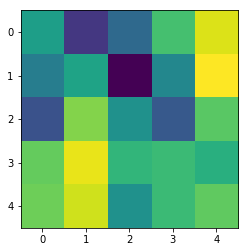

In [57]:
plt.imshow(f1[6])

### Submission

In [ ]:
def Evaluation_CV(X_train,K=3):
    folds = list(StratifiedKFold(n_splits=K, shuffle=True,random_state = 3).split(X_train, target_train))
    y_test_pred_log=0
    y_train_pred_log=0
    y_valid_pred_log = 0.0*target_train
    for j, (train_idx, valid_idx) in enumerate(folds):
        print('\n===================FOLD=',j+1)
        X_train_cv = X_train[train_idx]
        y_train_cv = target_train[train_idx]
        X_valid = X_train[valid_idx]
        y_valid= target_train[valid_idx]
        
        #Angle
#         X_angle_cv=X_angle[train_idx]
#         X_angle_hold=X_angle[test_idx]

        #define file path and get callbacks
        file_path = 'model save/Model 6-Advanced CNN with DA and self TL(cv3)/Model-6 cv'+str(j+1)+'.hdf5'
        Cnnmodel=cnnmodel(input_shape = (75,75,3),lr = 0.0001)
        Cnnmodel.load_weights(file_path)


#         callbacks = get_callbacks(filepath=file_path, patience=5)
#         gen_flow = gen_flow_for_two_inputs(X_train_cv, X_angle_cv, y_train_cv)
#         galaxyModel= getVggAngleModel()
#         galaxyModel.fit_generator(
#                 gen_flow,
#                 steps_per_epoch=24,
#                 epochs=100,
#                 shuffle=True,
#                 verbose=1,
#                 validation_data=([X_holdout,X_angle_hold], Y_holdout),
#                 callbacks=callbacks)

        #Getting the Best Model
        #Getting Training Score
        print('cv'+str(j+1))
        score = Cnnmodel.evaluate(X_train_cv, y_train_cv)
        print('Train loss:', score[0])
        print('Train accuracy:', score[1])
        #Getting Test Score
        score = Cnnmodel.evaluate(X_valid, y_valid)
        print('Valid loss:', score[0])
        print('Valid accuracy:', score[1])
        print('\n')

        #Getting validation Score.
        pred_valid=Cnnmodel.predict(X_valid)
        y_valid_pred_log[valid_idx] = pred_valid.reshape(pred_valid.shape[0])

        #Getting Test Scores
        temp_test=Cnnmodel.predict(X_test)
        y_test_pred_log+=temp_test.reshape(temp_test.shape[0])

        #Getting Train Scores
        temp_train=Cnnmodel.predict(X_train)
        y_train_pred_log+=temp_train.reshape(temp_train.shape[0])

    y_valid_pred_log=y_valid_pred_log/K
    y_train_pred_log=y_train_pred_log/K

    print('\n Train Log Loss Validation= ',log_loss(target_train, y_train_pred_log))
    print(' Test Log Loss Validation= ',log_loss(target_train, y_valid_pred_log))
    return y_test_pred_log

In [ ]:
preds = Evaluation_CV(X_train,K=5)
sub = test[['id']]
sub['is_iceberg'] = preds
sub.to_csv('5cv.csv',index = False)

### Submission(min max median stacking)

In [10]:
def test_scores(K=5):
    y_test_pred_log=0
    test_df = test_data[['id']]
    for j in range(K):
        print('\n===================FOLD=',j+1)
        file_path = 'model save/Model 8-Advanced CNN with DA(cv5)/Model-8 cv'+str(j+1)+'.hdf5'
        Cnnmodel = model_compile(cnnmodel(),lr = 0.0001,decay = 0, freezing_layers = None,weights_path = file_path)

        #Getting Test Scores
        temp_test=Cnnmodel.predict(X_test)
        test_df['cv'+str(j+1)]=temp_test.reshape(temp_test.shape[0])
    return test_df

In [17]:
test_df = test_scores()


===================FOLD= 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 71, 71, 128)       9728      
_________________________________________________________________
activation_21 (Activation)   (None, 71, 71, 128)       0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 35, 35, 128)       0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 33, 33, 256)       295168    
_________________________________________________________________
activation_22 (Activation)   (None, 33, 33, 256)

c:\users\yltbe\anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()



===================FOLD= 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 71, 71, 128)       9728      
_________________________________________________________________
activation_25 (Activation)   (None, 71, 71, 128)       0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 35, 35, 128)       0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 33, 33, 256)       295168    
_________________________________________________________________
activation_26 (Activation)   (None, 33, 33, 256)


===================FOLD= 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 75, 75, 3)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 71, 71, 128)       9728      
_________________________________________________________________
activation_37 (Activation)   (None, 71, 71, 128)       0         
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 35, 35, 128)       0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 33, 33, 256)       295168    
_________________________________________________________________
activation_38 (Activation)   (None, 33, 33, 256)

In [18]:
test_df

,id,cv1,cv2,cv3,cv4,cv5
0,5941774d,5.428893e-02,6.673208e-02,7.094257e-02,3.609517e-03,4.734804e-02
1,4023181e,5.245490e-01,4.921556e-01,3.735768e-01,2.362068e-01,3.767341e-01
2,b20200e4,7.215895e-06,5.210542e-08,7.925581e-10,2.667083e-08,4.645425e-06
3,e7f018bb,9.979774e-01,9.999882e-01,9.976949e-01,9.999983e-01,9.999951e-01
4,4371c8c3,1.210454e-01,9.455159e-04,3.490464e-02,3.091512e-03,4.910483e-05
5,a8d9b1fd,8.201791e-02,1.096915e-01,1.754192e-02,6.308465e-02,6.289902e-02
6,29e7727e,2.341684e-01,1.582016e-01,4.415979e-02,3.304548e-01,1.907021e-01
7,92a51ffb,9.991114e-01,9.999897e-01,9.985918e-01,9.999380e-01,9.999481e-01
8,c769ac97,3.057454e-05,1.249167e-04,1.259599e-06,1.479310e-07,2.700044e-09
9,aee0547d,1.977355e-09,3.014829e-10,8.679121e-09,9.400190e-12,3.189674e-13


In [19]:
def get_sub_mmm(test_df):
    prediction = test_df
    prediction['is_iceberg'] = np.where(np.all(prediction[prediction.columns[1:]]>0.9,axis = 1),
                                    np.max(prediction[prediction.columns[1:]],axis = 1),
                                     np.where(np.all(prediction[prediction.columns[1:]]<0.1,axis = 1),np.min(prediction[prediction.columns[1:]],axis = 1),np.median(prediction[prediction.columns[1:]],axis = 1)))
    sub = prediction[['id','is_iceberg']]
    sub.to_csv('sub.csv',index = False)
    return sub

In [20]:
sub = get_sub_mmm(test_df)

c:\users\yltbe\anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [21]:
sub

,id,is_iceberg
0,5941774d,3.609517e-03
1,4023181e,3.767341e-01
2,b20200e4,7.925581e-10
3,e7f018bb,9.999983e-01
4,4371c8c3,3.091512e-03
5,a8d9b1fd,6.308465e-02
6,29e7727e,1.907021e-01
7,92a51ffb,9.999897e-01
8,c769ac97,2.700044e-09
9,aee0547d,3.189674e-13
